# Camera: $\mu$Eye

Este es un documento para aprender a manejar la clase Camera de *py_lab* empleando la cámara uEye de IDS. También sirve como test de que el software funciona sin errores.

In [1]:
%load_ext autoreload
%autoreload 2

## Creación

En primer lugar hay que importar la clase, crear el objeto y abrir la camara.

In [2]:
from py_lab.camera import Camera
import numpy as np

Al crear el objeto, además de usar en nombre adecuado (uEye, que **NO** es el que se da por defecto), se le puede dar un factor de magnificación (M), y la longitud de onda (en mm, que es la unidad por defecto de py_lab).

In [4]:
# Dependiendo del modelo
cam = Camera(name="uEye", M=1, wavelength=None)     # Montaje del polarimetro
cam = Camera(name="uEye_SLM", M=1, wavelength=None) # Montaje del Pluto slave para Optica Digital
cam = Camera(name="uEye_LCD", M=1, wavelength=None) # Montaje del LCD para Optica Digital

Background cleared


In [6]:
cam.Open()

Gain must be between 1 and  8.52


**Nota:** Al hacer *Open*, se imprime la ganancia máxima de la cámara (ver más adelante).

Una vez creado el objeto, tiene las siguientes propiedades:

* **name** (str): Nombre de la cámara (ImagingSource).
* **dynamic_range** (int): Profundidad de los valores que puede tomar la cámara (8 bits).
* **resolution** (np.ndarray): Array con la resolucion actual.
* **pixel_size** (np.ndarray): Tamaño del pixel en x e y (2.2 x 2.2 um).
* **M** (float): Factor de magnificación.
* **wavelength** (float): Longitud de onda (para interactuar con Diffractio).
* **ROI** (dict): Dictionary containing the information about the Region Of Interest.
* **_object** (object): Objeto de la clase de los drivers de la camara.
* **_live** (bool): Guarda si el modo live está activo o no.

## Propiedades de la cámara

Lo normal es tener que cambiar alguna de las propiedades de la cámara. Esto se hace con los métodos *Set_Property* y *Set_Property_Auto*. Estas funciones tienen los siguientes argumentos de entrada:

* **name** (str): Nombre de la propiedad.
* **value**: Nuevo valor de la propiedad.

**Nota:**: A diferencia de las cámaras de Imaging Source, la propiedad de *Resolution* no acepta un string sino un array/lista/tupla de dos elementos (nº de píxeles en anchura y altura).

In [5]:
cam.Set_Property_Auto(name="Exposure", value=0)
cam.Set_Property(name="Exposure", value=10)
cam.Set_Property(name="Framerate", value=3)
cam.Set_Property_Auto(name="Resolution", value=0)
cam.Set_Property(name="Resolution", value=[2560,1920])

Background cleared
Background cleared
Background cleared
Property Resolution cannot be automatically handled by uEye
uEye camera can't set the resolution. Use Set_ROI method instead.
Background cleared


A diferencia de las cámaras Imaging Source, las uEye tienen dos maneras de manejar la ganancia. La habitual es igual que siempre (*Gain*). Acepta valores entre 1 y la ganancia máxima que se imprime al realizar el método *Open*. La segunda es *GainLinear*, que implementa un crecimiento lineal en la señal entre el 0% (no hay ganancia) y el 100% (el máximo de ganancia posible).

In [11]:
cam.Set_Property(name="Gain", value=5.2)
cam.Set_Property(name="GainLinear", value=45)

Background cleared
Background cleared


También se puede pedir leer las propiedades actuales con el método *Get_Property*, que utiliza los siguientes parámetros de entrada:

* **name** (str): Nombre de la propiedad.
* **value**: Nuevo valor de la propiedad.
* **verbose** (bool): Si es True, se imprime en pantalla el valor de la propiedad. Por defecto: False.

In [12]:
_ = cam.Get_Property(name="Resolution", verbose=True)
_ = cam.Get_Property(name="Exposure", verbose=True)
_ = cam.Get_Property(name="Framerate", verbose=True)
_ = cam.Get_Property(name="Gain", verbose=True)

The value of the property Resolution is [1280 1024].
The value of the property Exposure is 499.92283333333336.
The value of the property Framerate is 0.0.
The value of the property Gain is 3.74.


En el caso de la ganancia, solo se puede comprobar el parámetro *Gain*, no el *GainLinear*.

## Tomar imágenes

Tomar imágenes es el cometido principal de la cámara. Hay varios aspectos que hay que tener en cuenta para poder realizarlo correctamente.

### Preparqación de la cámara

En primer lugar, la cámara de ImagingSource necesita estar preparada para tomar imágenes. Para ello, hay que usar el método *Start_Live*, que tiene el siguiente argumento de entrada:

* **view** (bool): Si es True, se abrirá una ventana que mostrará lo que ve la cámara. Por defecto: True.

In [6]:
cam.Start_Live(view=True)

En caso de que se haya abierto una ventana, si el usuario la quiere cerrar tiene dos optiones:

1. Usar el método *Stop_Live*.
1. Con la ventana de la vista de la cámara activa, presionar la tecla Esc.

*py_lab* sabe en todo momento si la cámara está iniciada o no. Si se trata de tomar una imagen sin haber llamado al método *Start_Live*, *py_lab* lo hace antes de tratar de tomar la imagen (y después lo apaga). Sin embargo, hay que esperar un poco desde que se manda esta instrucción hasta que puede tomar la imagen, por lo que si se van a tomar muchas imágenes es recomendable que el usuario no olvide activarlo primero.

### Adquisición de la imagen

La imagen se toma con el método *Get_Image*, que emplea las siguientes variables de entrada:

* **wait_time** (float): Tiempo de espera (en segundos) antes de tomar la imagen. Si no se había activado *Start_Live*, ese tiempo se duplica. Por defecto: 1 ms.
* **monochannel** (bool): Si la imagen viene dada en formato de tres o cuatro colores y este parámetro es True, la pasa a blanco y negro.  Por defecto: True.
* **is_background** (bool): SI es True, *py_lab* guardará esta imagen como fondo para restar en futuras imágenes. Por defecto: False.
* **rest_background** (bool): Si hay un fondo guardado, lo restará a la imagen que tome. Por defecto: True.
* **diffractio** (bool): Si es True, el argumento de salida será un *Scalar_field_XY* de *diffractio* en lugar de un *numpy.ndarray*. Por defecto: False.
* **stadistics** (bool): Si es True, el programa imprime en la pantalla los valores máximo, mínimo, medi y desviación estándar de la imagen. Por defecto: False.
* **draw** (bool): Si es True, dibuja la imagen que toma. Por defecto: False.

*Get_Image* devuelve la imagen tomada como un array de numpy (salvo si *diffractio* se le dio como True) cuyos datos son enteros.

Lo primero que se debe hacer en un experimento es tomar una imagen del fondo. Las condiciones en que se toma este fondo dependen del experimento. Las más habituales son con toda fuente de luz apagada, o con el SLM con un mapa de fase constante.

In [9]:
_ = cam.Get_Image(is_background=True, stadistics=True)

Staistics of the image:
  - Max:  0.0.
  - Min:  0.0.
  - Mean: 0.0
  - Std:  0.0


Una vez tomado el fondo, se puede proceder a tomar más imágenes.

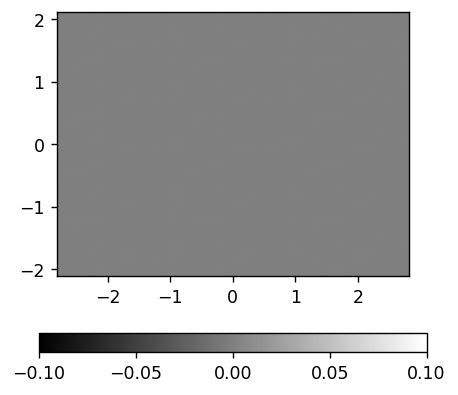

In [10]:
image = cam.Get_Image(draw=True)

Hay que tener muy en cuenta que, si se cambia alguna de las propiedades de la cámara que pudieran afectar a los niveles de gris (Exposure, Gain, etc.) o a la reslución (Resolution), el fondo guardado ya no será válido, por lo que se eliminará.

### Salvar la imagen

Puesto que la imagen devuelta por *Get_Image* es una rray de numpy, se puede guardar empleando la función *savez* de numpy:

In [25]:
np.savez('Archivo.npz', image=image)

Puede ser recomendable salvar una imagen en formato propio de una imagen (png, jpg, etc). Para ello, al tomar la imagen, se debe emplear el método *Save_Image* en lugar de *Get_Image*. Posee los mismos siguientes argumentos de entrada:

* **file_name** (str): Nombre del archivo a crear: Por defecto: un nombre automático basado en la fecha en formato bmp.
* **path** (str): Lugar donde se colocará el nuevo archivo.
* **wait_time** (float): Tiempo de espera (en segundos) antes de tomar la imagen. Si no se había activado *Start_Live*, ese tiempo se duplica. Por defecto: 1 ms.
* **monochannel** (bool): Si la imagen viene dada en formato de tres o cuatro colores y este parámetro es True, la pasa a blanco y negro.  Por defecto: True.
* **is_background** (bool): SI es True, *py_lab* guardará esta imagen como fondo para restar en futuras imágenes. Por defecto: False.
* **rest_background** (bool): Si hay un fondo guardado, lo restará a la imagen que tome. Por defecto: True.
* **stadistics** (bool): Si es True, el programa imprime en la pantalla los valores máximo, mínimo, medi y desviación estándar de la imagen. Por defecto: False.
* **draw** (bool): Si es True, dibuja la imagen que toma. Por defecto: False.
* **draw_external** (bool): SI es True, se abre la imagen con el visor de imágenes predeterminado del sistema operatico. Por defecto: False.
* **return_array** (bool): Si es True, se devuelve la imagen como argumento de salida. Por defecto: False.

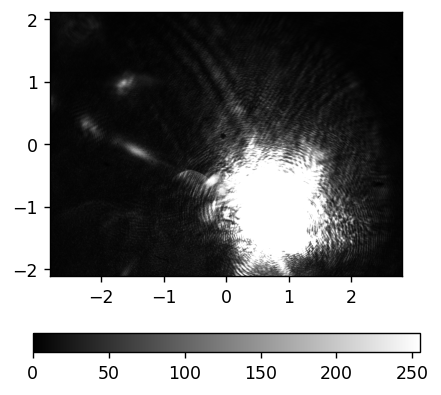

In [26]:
cam.Save_Image('Foto.bmp', path=r"C:", draw=True)

### Manejo del fondo

Para recuperar la imagen tomada de fondo, se usa el método *Get_Backgrund*:

* **monochannel** (bool): Si la imagen viene dada en formato de tres o cuatro colores y este parámetro es True, la pasa a blanco y negro.  Por defecto: True.
* **draw** (bool): Si es True, dibuja la imagen que toma. Por defecto: False.

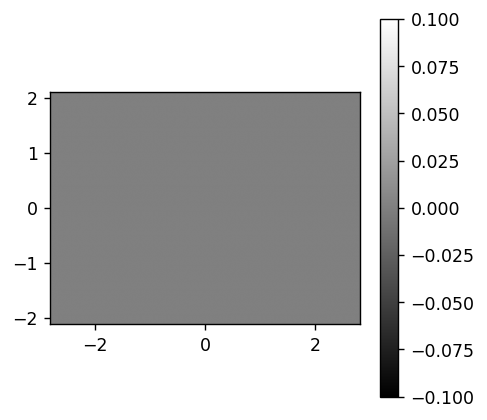

In [27]:
background = cam.Get_Background(draw=True)

También se puede eliminar el fondo si ya no es necesario. Esto ocurre automáticamente al cambiar las propiedades de la cámara que lo hacen obsoleto, como Exposure, Gain o Resolution.

In [28]:
cam.Clear_Background()

Background cleared


## Region de interes (ROI)

Se puede pedir a la cámara que no emplee todo el chip, para medir, sino únicamente una parte. Para ello, se emplea el método *Set_ROI*, que tiene los siguientes parámetros:

* **width**: Anchura de la ROI.
* **height**: Altura de la ROI.
* **x**: Posición horizontal del pizel de más a la izquierda de la ROI.
* **y**: Posición vertical del píxel de más arriba de la ROI.

Si alguno de ellos no se especifica, se tomará el último valor usado. SI no se usó previamente ningún valor, se usará 0 como valor por defecto para *x* e *y*, y la resolución máxima menos *x* e *y* para *width* y *height* respectivamente.

In [29]:
cam.Set_ROI(width=1200, height=1200, x=1000, y=1900)

The value of the property resolution is [2560 1920].
ROI y (1900) plus height (1200) higher than resolution (1920). x changed to maximum.


Se puede eliminar la elección de ROI con el método *Clear_ROI*:

Se puede obtener el valor actual de *x*, *y*, *width* y *height* actuales:

In [31]:
width, height, x, y = cam.Get_ROI(verbose=True)

Region Of Interest (ROI):
 - Width  = 2560
 - Height = 1920
 - x      = 0
 - y      = 0


In [30]:
cam.Clear_ROI()

## Parar la imagen de video

Se puede parar la imagen de la cámara de dos maneras. La primera es haciendo click en la ventana de la cámara y pulsando la tecla *Esc*. La segunda es usando el método *Stop_Live*.

In [9]:
cam.Stop_Live()

## Cerrar la cámara

Cerrar la cámara es sencillo, solo hay que invocar el método *Stop_Live*. Esto permitiría emplear la cámara con otro software diferente, y aún así mantener el objeto *cam* creado para reanudar rápidamente el programa inicializando de nuevo la cámara.

In [10]:
cam.Close()